This notebook contains the analysis for the WEO scenarios. 

For questions about this notebook, please contact Guarav Ganti <gaurav.ganti@climateanalytics.org>.

In [1]:
import os 
import pyam 
import pandas as pd 
import matplotlib.pyplot as plt 
from harmonization import harmonize_data
import utils 
import silicone.time_projectors as timeproj 
import silicone.multiple_infillers as mi 
import silicone.database_crunchers as cr 

<IPython.core.display.Javascript object>

# Read in data

Here we load the following data:
* Historic data 
* Scenario data for WEO 2020
* The infilling database 

In [2]:
# Historic data 
df_hist = pyam.IamDataFrame(
    os.path.join('data','history.csv')
)

# WEO scenario data 
weo_2020 = pyam.IamDataFrame(
    os.path.join('data','institutional_scenario_data.xlsx'),
    sheet_name = 'WEO2020'
)

# Infilling database
infilling_db = pyam.IamDataFrame(
    os.path.join('data','infilling_database.csv')
)

pyam - INFO: Running in a notebook, setting up a basic logging config at level INFO
pyam.core - INFO: Reading file data/history.csv
pyam.core - INFO: Reading file data/institutional_scenario_data.xlsx
pyam.core - INFO: Reading file data/infilling_database.csv


# Harmonization 

Now we harmonize the available data. The scenarios should be harmonized with the method ```reduce_ratio_2040```.

In [3]:
emission_list = ['Emissions|CO2|Energy and Industrial Processes']

In [4]:
harmonized_data = harmonize_data(
    df_hist,
    weo_2020,
    emission_list 
)

/data/ubuntu-znicholls/miniconda3/envs/institutional_scenarios/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/ubuntu-znicholls/miniconda3/envs/institutional_scenarios/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/ubuntu-znicholls/miniconda3/envs/institutional_scenarios/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/ubuntu-znicholls/miniconda3/envs/institutional_scenarios/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/ubuntu-znicholls/miniconda3/envs/institutional_scenarios/lib/python3.8/site-packages/numpy

Harmonizing scenario: SDS_2020
Harmonizing scenario: STEPS_2020


# Process infilling database for filtering 

In [5]:
infilling_db = (
    infilling_db
    .filter(model = 'MESSAGE V.3', keep=False)
    .filter(year = range(2010,2110,10))
)

# Constant Quantile Extension 

We use the Constant Quantile Extension method to extend the data from the BP scenarios until 2100.

In [6]:
extender = timeproj.ExtendLatestTimeQuantile(infilling_db)
filler = extender.derive_relationship(emission_list[0])

In [7]:
extended_data = (
    harmonized_data
    .append(filler(harmonized_data))
)

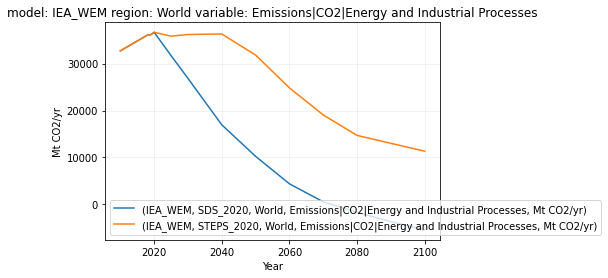

In [8]:
fig, ax = plt.subplots()
extended_data.plot(ax=ax)
ax.grid(alpha=0.2)

# Infill required data and construct scen file 

We use the Quantile Rolling Windows method to infill the data with sensitivities assessed to the Equal Quantile Walk and RMS closest methods.

In [9]:
method_label = {
    'eqw': cr.EqualQuantileWalk,
    'qrw': cr.QuantileRollingWindows,
    'rms': cr.RMSClosest
}

In [10]:
result = pd.DataFrame()

In [11]:
for label in method_label.keys():
    for i, scen in enumerate(extended_data.scenario):
        print('Crunching {} with {}'.format(scen, label))
        # Infill necessary variables
        infilled_data = mi.infill_all_required_variables(
            extended_data.filter(scenario=scen),
            infilling_db,
            emission_list,
            utils.gases_to_infill,
            method_label[label],
            output_timesteps = list(range(2010,2110,10))
        )

        infill_to_append = infilled_data.copy()
        infill_to_append['model'] = label

        result = result.append(infill_to_append.timeseries())
        
        # Construct the scen file
        utils.construct_scen_file(
            infilled_data,
            os.path.join(
                "scen_files",
                "weo_{}_{}".format(scen,label)
            )
        )

Crunching SDS_2020 with eqw


Filling required variables: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


Crunching STEPS_2020 with eqw


Filling required variables: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


Crunching SDS_2020 with qrw


Filling required variables: 100%|██████████| 21/21 [00:13<00:00,  1.57it/s]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


Crunching STEPS_2020 with qrw


Filling required variables: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


Crunching SDS_2020 with rms


Filling required variables: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


Crunching STEPS_2020 with rms


Filling required variables: 100%|██████████| 21/21 [00:28<00:00,  1.35s/it]
<ipython-input-11-29fca34ab374>:15: DeprecationWarning: Item assignment is deprecated and will be removed in future versions. Please use `set_meta` or `rename`.
  infill_to_append['model'] = label


In [12]:
result = pyam.IamDataFrame(result)

In [13]:
result.to_excel(
    os.path.join('output', 'weo_infilled_data.xlsx')
)

# Plot effect of harmonization

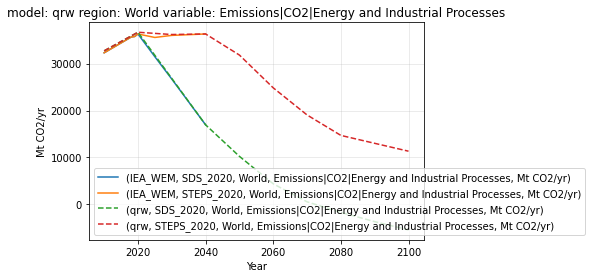

In [14]:
fig, ax = plt.subplots()

weo_2020.filter(variable='Emissions|CO2|Energy and Industrial Processes').plot(ax=ax)
result.filter(model = 'qrw', variable='Emissions|CO2|Energy and Industrial Processes').plot(ax=ax, linestyle='dashed')

ax.grid(alpha=0.3)